Now that we have a basic understanding of embedding models, we can start learning about Retrieval Augmented Learnings (commonly known as RAGs). 

So, there are multiple complicated terms that form the abbreviation RAG:

i.   Retrieve   
ii.  Augment  
iii. Generate  

The concepts will get clearer as we break down the image below.

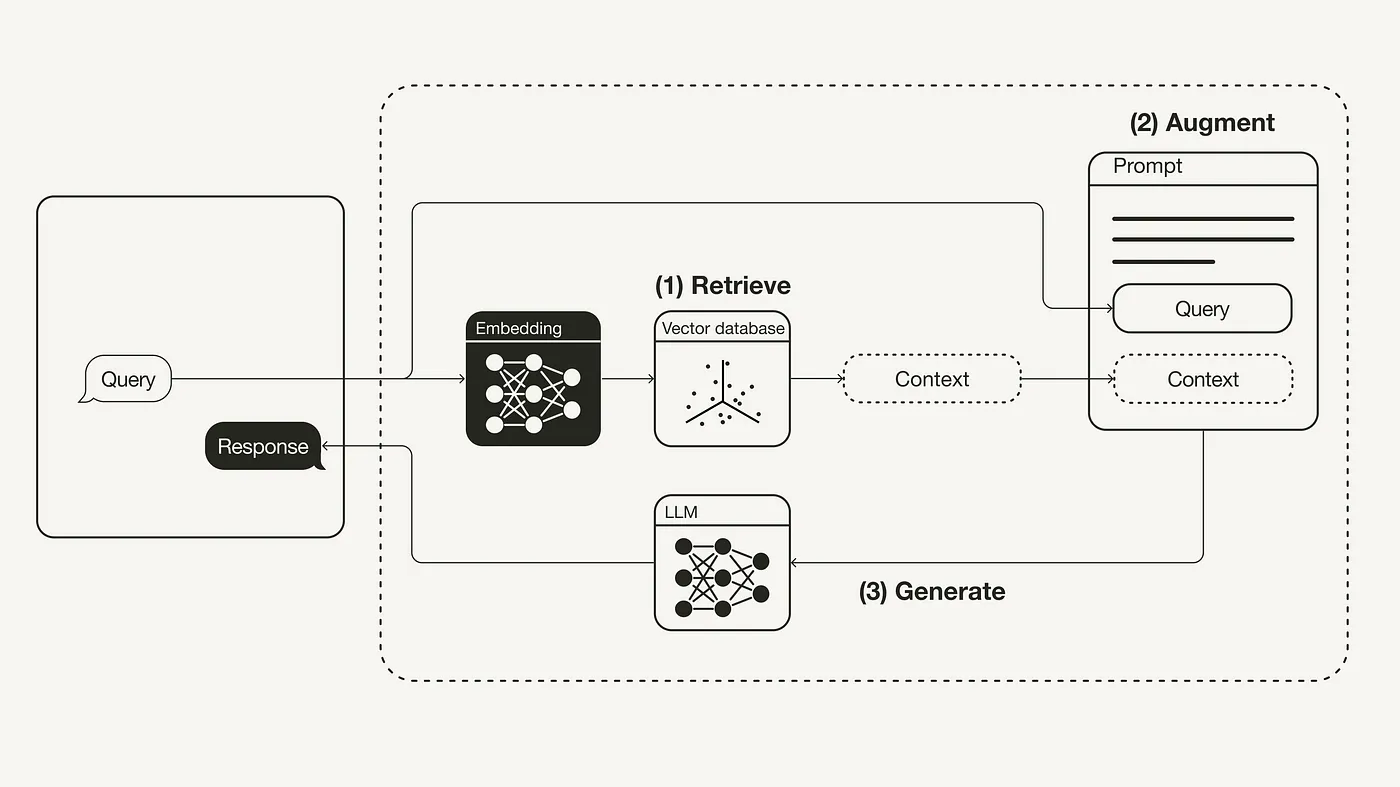

But before we dive into the above image, lets quickly recap how a model like ChatGPT or Gemini works.

At the abstract level, it is a very simple two step process:

**Step 1**: We input a prompt.  
**Step 2**: Based on the prompt, the underlying transformer model behind ChatGpt or Gemini processes the nautral language prompt and generates the corresponding out.  




But there are certain limitations in the approach. Though the underying transformer model is good at interpretation and generation of natural lanaguage. It faces the following challenges:

- i. The models are trained on the internet content - it might not generate relevant output when prompted for information that is not publically available on the internet.

- ii. The models are trained upto a certain date - it might not generate relevant output when prompted for content and information that have happened after the training completion date of the model.

- iii. Most importantly, the models are generalized. This means that the model can only produce generic outputs and might not perform as per expectations when prompted for specific deep-dive concepts related to a particular topic.

**Question**: In addition to the above three pointers, do you see any other challeneges or limitations for the existing transformer LLM models?

So to tackle the challenges - ** **RAGs TO THE RESCUE** **  
RAG based LLMs help solve these challenegs by implementing the three steps mentioned above - Retrieve, Augment and Generate.

#### Interplay between RAG-LLMs and Embedding Models.

RAG based models heavily depend on the Embedding Models that we discussed in the part-1 of this tutorial. 


Let's understand this with an example: Suppose you work for a scientific organization. All the research papers for this organization are available within the organization network and not available publicly on the internet. So how do you leverage the power of LLM in association with years of research paper that your organization might have.


#### STEP 1: Setting Up the Embedding Model:

For the tutorial purposes - we have a csv file corresponding to the 10000 files from ArXiV dataset that are related to "astro-ph"

In [1]:

import pandas as pd

## Loading the pandas dataframe corresponding to the 10000 files from ArXiV dataset that are related to "astro-ph"
astro_df = pd.read_csv('astro_df_red.csv')

In [2]:
astro_df.columns

Index(['id', 'title', 'abstract', 'categories'], dtype='object')

In [3]:
astro_df.head()

,id,title,abstract,categories
0,704.0009,"The Spitzer c2d Survey of Large, Nearby, Inste...",We discuss the results from the combined IRA...,astro-ph
1,704.0017,Spectroscopic Observations of the Intermediate...,Results from spectroscopic observations of t...,astro-ph
2,704.0023,ALMA as the ideal probe of the solar chromosphere,"The very nature of the solar chromosphere, i...",astro-ph
3,704.0044,Astrophysical gyrokinetics: kinetic and fluid ...,We present a theoretical framework for plasm...,astro-ph nlin.CD physics.plasm-ph physics.spac...
4,704.0048,Inference on white dwarf binary systems using ...,We report on the analysis of selected single...,gr-qc astro-ph


In [23]:
# Setup the embedding, we are using the MiniLM model here

from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import DataFrameLoader

embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L12-v2")

## defining the column from the dataframe that is used to create "documents".  
loader = DataFrameLoader(astro_df, page_content_column="abstract") 
documents = loader.load()

#### STEP 2: Setting Up the Vector Store:

**What is a Vector Store?**

As we learnt in the last tutorial - embedding models create vector embeddings from texts. Once these embeddings are created, we need to store these embeddings in the database for real-time access and retrieval of these embeddings.  

The type of databases that store these vector embeddings are called "Vector Stores". For the purpose of the tutorial we will use an open source vector store called "Qdrant" as shown below. We will dive into the further details of Vector Store in subsequent tutorials.

In the below code, 
- Vector store works along with embedding model to create vector embeddings.
- Vector embeddings are stored in the Qdrant Vector database collection.

In [7]:
import os

#### Setting up the database where we will store these embeddings:
from langchain_community.vectorstores import Qdrant

qdrant_path="./local_qdrant_tutorial"
qdrant_collection="arxiv_astro-ph_abstracts-df"

if os.path.exists(qdrant_path):
    print(f"Loading existing Qdrant collection '{qdrant_collection}'")
    from qdrant_client import QdrantClient
    # If the Qdrant Vector Database Collection already exists, load it
    client = QdrantClient(path=qdrant_path)
    qdrant = Qdrant(
        client=client,
        collection_name=qdrant_collection,
        embeddings=embedding
    )
else:
    print(f"Creating new Qdrant collection '{qdrant_collection}' from {len(documents)} documents")
    # Load the documents into a Qdrant Vector Database Collection
    # this will save locally in the current directory as sqlite
    qdrant = Qdrant.from_documents(
        documents,
        embedding,
        path=qdrant_path,
        collection_name=qdrant_collection,
    )

Creating new Qdrant collection 'arxiv_astro-ph_abstracts-df' from 10000 documents


#### STEP 3: RETRIEVAL STEP - The 'R' in RAG...

Let's say we want to know further details about the paper from which the following 3-4 lines have been sourced.

In the first step, we retrieve the document to which the following lines belong.

In [9]:
statement = """Our results illustrate how metals, produced by the first stars,
led to a transition from the high-mass star formation mode of Pop III stars, to
the low-mass mode that dominates today. We ran hydrodynamic simulations with
cosmological initial conditions in the standard LambdaCDM model"""

In this step, the vector store and embedding model work together to get the most relevant document for the above statement by completing the following sub-steps:

Sub-Steps:

i.)   Embedding model creates a vector embedding for the above statement, lets call it VE-Original  
ii.)  Vector Store tries to find the closest matching vector embedding from its collection, lets call it VE-Matched.   
iii.) Embedding Model converts back the VE-matched vector embeddings into human legible natural language text. 

In [12]:
# Setup the retriever for later step
retriever = qdrant.as_retriever(search_type="similarity", search_kwargs={"k": 2})

The "search_kwargs" signifies the number of documents to return based on the "search_type".  
In the above example, we have setup a retriever that gives back top "2" documents based on the "similarity" search.

In [13]:
# actual statement retrieval step
found_docs = retriever.get_relevant_documents(statement)

/Users/anujsinha/anaconda3/envs/ssec-scipy2024/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [20]:
# Helper function for document formatting
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

print(type(found_docs))
print(f"This is the rank 1 document.\n\n {found_docs[0]} \n\n")
print(f"This is the rank 2 document.\n\n {found_docs[1]} \n\n")

<class 'list'>
This is the rank 1 document.

 page_content='  We observe a sharp transition from a singular, high-mass mode of star\nformation, to a low-mass dominated mode, in numerical simulations, at a\nmetallicity of 10^-3 Zsolar. We incorporate a new method for including the\nradiative cooling from metals into adaptive mesh-refinement hydrodynamic\nsimulations. Our results illustrate how metals, produced by the first stars,\nled to a transition from the high-mass star formation mode of Pop III stars, to\nthe low-mass mode that dominates today. We ran hydrodynamic simulations with\ncosmological initial conditions in the standard LambdaCDM model, with\nmetallicities, from zero to 10^-2 Zsolar, beginnning at redshift, z = 99. The\nsimulations were run until a dense core forms at the center of a 5 x 10^5\nMsolar dark matter halo, at z ~ 18. Analysis of the central 1 Msolar core\nreveals that the two simulations with the lowest metallicities, Z = 0 and 10^-4\nZsolar, contain one clump 

#### STEP 4: AUGMENTATION STEP - The 'A' in RAG...

In the previous step, we retrieved the most relevant document based on the statement.

In the next step, we use the retrieved document along with the prompt to the transformer model.  
The combination of the retrieved document along with the prompt is now sent to the transformer model.

This helps to provide the transformer with the context for the prompt - also called **"THE AUGMENTED PROMPT"**

In [39]:
from pathlib import Path
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

In [40]:
model_name = "allenai/OLMo-1B"

In [41]:
# Download the model and its configuration file locally
# from the Hugging Face Hub
# we will only download the configuration file and the model as safetensors file
local_dir = Path("../OLMo-1B")
model_path = snapshot_download(
    repo_id=model_name,
    ignore_patterns=["*.bin"],
    local_dir=local_dir,
    local_dir_use_symlinks=True)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [42]:
olmo = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    local_files_only=True
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [43]:
# Setup the text generation pipeline with the OLMo model
olmo_pipe = pipeline(
    task="text-generation",
    model=olmo,
    tokenizer=tokenizer,
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=400,
)

##### Setup the langchain pipeline for the OLMo model


In [46]:
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
llm = HuggingFacePipeline(pipeline=olmo_pipe)

In [49]:
# https://github.com/allenai/open-instruct/blob/main/eval/templates.py
def create_prompt_with_olmo_chat_format(messages, bos="|||IP_ADDRESS|||", eos="|||IP_ADDRESS|||", add_bos=True):
    formatted_text = ""
    for message in messages:
        if message["role"] == "system":
            formatted_text += "<|system|>\n" + message["content"] + "\n"
        elif message["role"] == "user":
            formatted_text += "<|user|>\n" + message["content"] + "\n"
        elif message["role"] == "assistant":
            formatted_text += "<|assistant|>\n" + message["content"].strip() + eos + "\n"
        else:
            raise ValueError(
                "Olmo chat template only supports 'system', 'user' and 'assistant' roles. Invalid role: {}.".format(message["role"])
                )
    formatted_text += "<|assistant|>\n"
    formatted_text = bos + formatted_text  # forcibly add bos
    return formatted_text


no_context_prompt_template = PromptTemplate(
    input_variables=["question"],
    template=create_prompt_with_olmo_chat_format(messages=[
        {"role": "system", "content": "You are an astrophysics expert."}, 
        {"role": "user", "content": "{question}"}
    ]),
)

with_context_prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template=create_prompt_with_olmo_chat_format(messages=[
        {"role": "system", "content": "You are an astrophysics expert. Read the context:\n{context}"}, 
        {"role": "user", "content": "{question}"}
    ]),
)

In [51]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

question = "what are pop three stars?"
augmented_prompt = {"context":found_docs[0], "question": question }

llm_chain = llm | StrOutputParser()
no_context_chain =  no_context_prompt_template | llm_chain
rag_chain = with_context_prompt_template | llm_chain


#### STEP 5: Generation Step - The 'G' in RAG.

Based on the augmented prompt that is passed into the transformer model. We "generate" the output.

In [53]:
rag_answer = rag_chain.invoke(augmented_prompt)